# Image Processing Project

Efficient Model Stealing Defence with Noise Transition Matrix

# Part 1: PyTorch Code

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [2]:
# Simulated simple model (e.g., pre-trained classifier)
class SimpleModel(nn.Module):
    def __init__(self, input_dim=10, num_classes=3):
        super().__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

In [3]:
# Define a noise transition matrix (NTM)
def create_noise_transition_matrix(num_classes=3, noise_level=0.2):
    T = np.eye(num_classes) * (1 - noise_level)
    for i in range(num_classes):
        for j in range(num_classes):
            if i != j:
                T[i][j] = noise_level / (num_classes - 1)
    return torch.tensor(T, dtype=torch.float32)

In [4]:
# Defense query function
def defended_query(model, x, T):
    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        true_label = torch.argmax(probs, dim=1).item()

        # Sample noisy label using the noise transition matrix
        noisy_label_probs = T[true_label].numpy()
        noisy_label = np.random.choice(len(noisy_label_probs), p=noisy_label_probs)
        return noisy_label

In [5]:
# Example usage
num_classes = 3
model = SimpleModel(num_classes=num_classes)
x_query = torch.rand((1, 10))  # Random query input
T = create_noise_transition_matrix(num_classes=num_classes, noise_level=0.3)

noisy_output = defended_query(model, x_query, T)
print("Noisy returned label:", noisy_output)

Noisy returned label: 0


# Part 2: Code with MNIST Test Dataset

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# 1. Simple CNN Model for MNIST
class MNISTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
# 2. Create Noise Transition Matrix
def create_noise_transition_matrix(num_classes=10, noise_level=0.2):
    T = np.eye(num_classes) * (1 - noise_level)
    for i in range(num_classes):
        for j in range(num_classes):
            if i != j:
                T[i][j] = noise_level / (num_classes - 1)
    return torch.tensor(T, dtype=torch.float32)

In [9]:
# 3. Defense Query Function
def defended_query(model, x, T):
    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        true_label = torch.argmax(probs, dim=1).item()

        noisy_label_probs = T[true_label].numpy()
        noisy_label = np.random.choice(len(noisy_label_probs), p=noisy_label_probs)
        return noisy_label

In [10]:
# 4. Load MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [11]:
# 5. Initialize model, optimizer
model = MNISTModel()
optimizer = optim.Adam(model.parameters())

In [12]:
# Train very quickly on a few batches just for demo
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

for epoch in range(1):  # quick training, not perfect
    for batch_idx, (data, target) in enumerate(trainloader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx > 100:  # only train on ~100 mini-batches for speed
            break

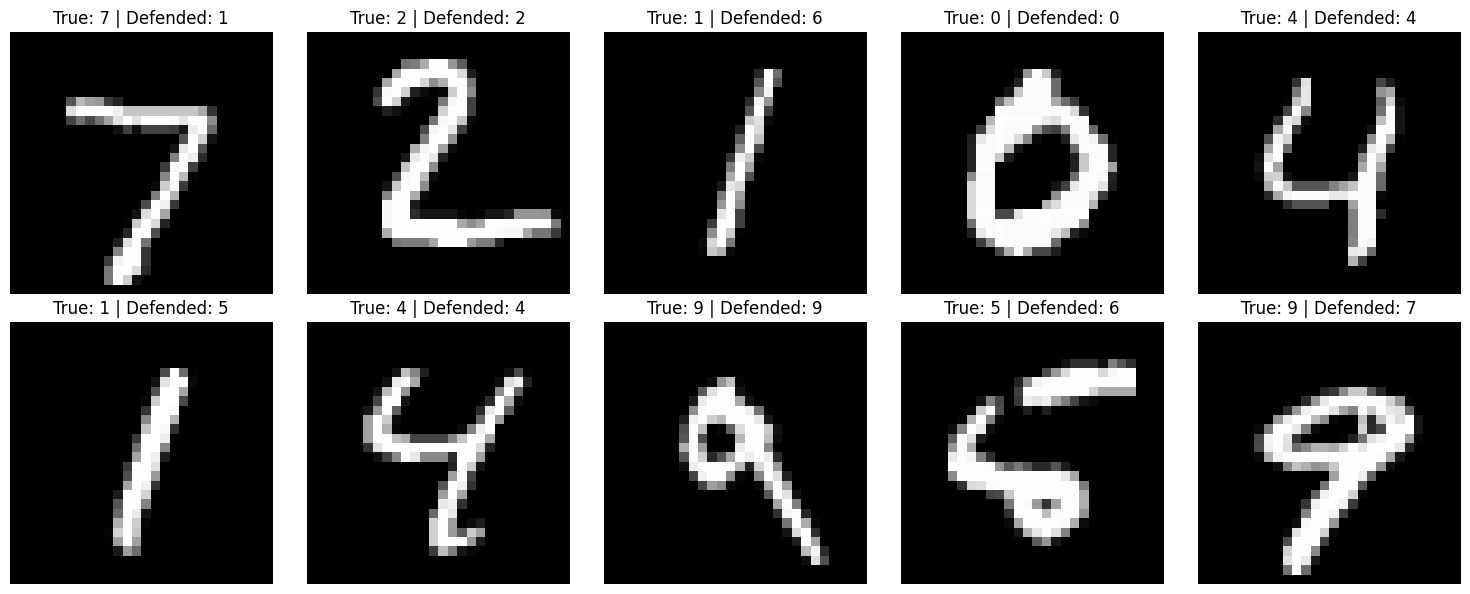

In [13]:
# 6. Apply defense to test images
T = create_noise_transition_matrix(num_classes=10, noise_level=0.3)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()

for idx in range(10):
    img, label = testset[idx]
    defended_label = defended_query(model, img.unsqueeze(0), T)

    axs[idx].imshow(img.squeeze(), cmap='gray')
    axs[idx].set_title(f"True: {label} | Defended: {defended_label}")
    axs[idx].axis('off')

plt.tight_layout()
plt.show()